In [1]:
import os, sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))

## Задание для разработки модуля обучения моделей с ограничением на свойства модели

In [2]:
import bamt.Networks as Nets
import bamt.Preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from pgmpy.estimators import K2Score

In [3]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (5, 3.8)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Извлечение данных и препроцессинг

In [4]:
data = pd.read_csv(r'../data/mehra-complete.csv')
data.columns

Index(['Unnamed: 0', 'Region', 'Zone', 'Type', 'Year', 'Season', 'Month',
       'Day', 'Hour', 'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd',
       'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'],
      dtype='object')

In [5]:
cols = ['Region', 'Type', 'Year', 'Season', 'Month', 'Zone',
        'Altitude', 't2m', 'ws', 'wd',
        'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']

data = data[cols].dropna()

In [6]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(encode='ordinal')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

info = p.info

### Обучение структуры и параметров БС

Инициализация БС с разрешенными logit узлами

In [7]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True)

Первая стадия обучения структуры - инициализация узлов

In [8]:
bn.add_nodes(info)

Вторая стадия обучения структуры - изменение узлов в соответствии с заданными параметрами и наследственностью. 

Выбираются скор-функция и родительские узлы

In [9]:
params = {'init_nodes': ['Type', 'Year', 'Month', 'Altitude', 'Zone'],
          'init_edges': [('Month', 't2m')]} # since mean month temperature depends on month and not vice versa

bn.add_edges(discretized_data, scoring_function=('K2',K2Score),  params=params)

In [10]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Type,Discrete,disc,[],[]
1,Year,Discrete,disc_num,[],[]
2,Month,Discrete,disc_num,[],[]
3,Zone,Discrete,disc,[],[]
4,Altitude,MixtureGaussian,cont,[],[]
5,wd,MixtureGaussian,cont,[],[]
6,t2m,ConditionalMixtureGaussian,cont,[Month],[disc_num]
7,pm10,ConditionalMixtureGaussian,cont,"[Year, Zone]","[disc_num, disc]"
8,ssr,MixtureGaussian,cont,[t2m],[cont]
9,CVD60,MixtureGaussian,cont,[t2m],[cont]


### Обучение с разными классификаторами logit узлов

Установим разные типы классификаторов для logit узлов, будем использовать доступные RandomForest, DecisionTree, KNeighbour.

Инициализируем и обучим первую модель с классификатором RandomForestClassifier для всех узлов типа logit

In [11]:
bn_1 = Nets.HybridBN(has_logit=True, use_mixture=True)
bn_1.add_nodes(info)
bn_1.add_edges(discretized_data, scoring_function=('K2',K2Score), params=params)
bn_1.get_info()

,name,node_type,data_type,parents,parents_types
0,Type,Discrete,disc,[],[]
1,Year,Discrete,disc_num,[],[]
2,Month,Discrete,disc_num,[],[]
3,Zone,Discrete,disc,[],[]
4,Altitude,MixtureGaussian,cont,[],[]
5,wd,MixtureGaussian,cont,[],[]
6,t2m,ConditionalMixtureGaussian,cont,[Month],[disc_num]
7,pm10,ConditionalMixtureGaussian,cont,"[Year, Zone]","[disc_num, disc]"
8,ssr,MixtureGaussian,cont,[t2m],[cont]
9,CVD60,MixtureGaussian,cont,[t2m],[cont]


In [12]:
bn_1.set_classifiers(classifiers={'Season': RandomForestClassifier(),
                                  'Region': RandomForestClassifier()})

Инициализируем и обучим вторую модель с классификатором DecisionTreeClassifier для всех узлов типа logit

In [13]:
bn_2 = Nets.HybridBN(has_logit=True, use_mixture=True)
bn_2.add_nodes(info)
bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score), params=params)
bn_2.set_classifiers(classifiers={'Season': DecisionTreeClassifier(),
                                 'Region': DecisionTreeClassifier()})
bn_2.get_info()

,name,node_type,data_type,parents,parents_types
0,Type,Discrete,disc,[],[]
1,Year,Discrete,disc_num,[],[]
2,Month,Discrete,disc_num,[],[]
3,Zone,Discrete,disc,[],[]
4,Altitude,MixtureGaussian,cont,[],[]
5,wd,MixtureGaussian,cont,[],[]
6,t2m,ConditionalMixtureGaussian,cont,[Month],[disc_num]
7,pm10,ConditionalMixtureGaussian,cont,"[Year, Zone]","[disc_num, disc]"
8,ssr,MixtureGaussian,cont,[t2m],[cont]
9,CVD60,MixtureGaussian,cont,[t2m],[cont]


Инициализируем и обучим третью модель с классификатором KNeighborsClassifier для всех узлов типа logit

In [14]:
bn_3 = Nets.HybridBN(has_logit=True, use_mixture=True)
bn_3.add_nodes(info)
bn_3.add_edges(discretized_data, scoring_function=('K2',K2Score), params=params)
bn_3.set_classifiers(classifiers={'Season':  KNeighborsClassifier(),
                                 'Region':  KNeighborsClassifier()})

### Параметрическое обучение БС и сэмплирование

In [15]:
bn_1.fit_parameters(data)

2022-10-08 18:08:39,089 | WARNING  | Nodes.py-fit_parameters-0666 | Region::Pickle failed. BAMT will use Joblib. | invalid load key, '@'.


In [16]:
bn_2.fit_parameters(data)

2022-10-08 18:12:37,635 | WARNING  | Nodes.py-fit_parameters-0666 | Region::Pickle failed. BAMT will use Joblib. | 'tuple' object is not callable
2022-10-08 18:12:37,679 | WARNING  | Nodes.py-fit_parameters-0666 | Season::Pickle failed. BAMT will use Joblib. | 'tuple' object is not callable


In [17]:
bn_3.fit_parameters(data)

In [18]:
synth_data_RF = bn_1.sample(1000, parall_count=5)

100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s]


In [19]:
synth_data_DT = bn_2.sample(1000, parall_count=5)

100%|██████████| 1000/1000 [00:23<00:00, 41.76it/s]


In [20]:
synth_data_KN = bn_3.sample(1000, parall_count=5)

100%|██████████| 1000/1000 [00:28<00:00, 35.08it/s]


### Выводы о полученных структурах

Ниже приводится сравнение исходных данных и распределений, смоделированных каждой из структур для узлов типа logit.

Видно, что в модель с классификаторами Decision Tree (DT) дает для узлов Region моделирует распределение, значительно отличающиеся от исходного. Метод ближайшего соседа (KN) демонстрирует лучший результат для узла Region

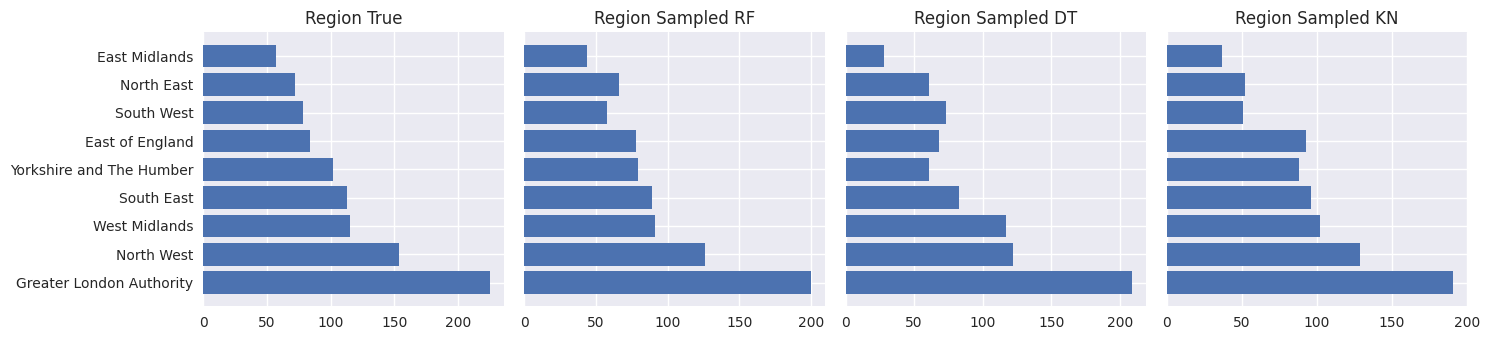

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5), sharey=True)
ax[0].set_title(f'Region True')
ax[1].set_title(f'Region Sampled RF')
ax[2].set_title(f"Region Sampled DT")
ax[3].set_title(f"Region Sampled KN")

ax[0].barh(data['Region'].value_counts().index, data['Region'].value_counts().values)
ax[1].barh(synth_data_RF['Region'].value_counts().index, synth_data_RF['Region'].value_counts().values)
ax[2].barh(synth_data_DT['Region'].value_counts().index, synth_data_DT['Region'].value_counts().values)
ax[3].barh(synth_data_KN['Region'].value_counts().index, synth_data_KN['Region'].value_counts().values)
plt.tight_layout()

Для узлов Season хуже всего распределение моделируется структурой с классификатороми RF. KN дает наиболее близкий результат.

Text(0.5, 1.0, 'Season Sampled KN')

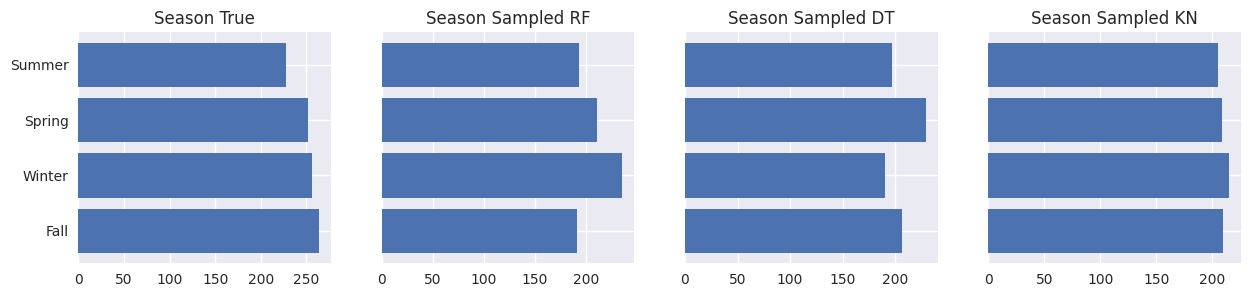

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

ax[0].barh(data['Season'].value_counts().index, data['Season'].value_counts().values)
ax[1].barh(synth_data_RF['Season'].value_counts().index, synth_data_RF['Season'].value_counts().values)
ax[2].barh(synth_data_DT['Season'].value_counts().index, synth_data_DT['Season'].value_counts().values)
ax[3].barh(synth_data_KN['Season'].value_counts().index, synth_data_KN['Season'].value_counts().values)

ax[0].set_title(f'Season True')
ax[1].set_title(f'Season Sampled RF')
ax[2].set_title(f"Season Sampled DT")
ax[3].set_title(f"Season Sampled KN")